In [9]:
!pip install mne
!pip install mne-icalabel
!pip install keras-tuner


In [ ]:
# Import necessary libraries
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
FS = 128  # Sampling frequency
global METADATA_COLUMNS
METADATA_COLUMNS =  [
    'EEG.Counter', 'EEG.Interpolated', 'EEG.RawCq', 'EEG.Battery',
    'EEG.BatteryPercent', 'EEG.MarkerHardware'
]

print("Libraries imported and constants initialized.")

Libraries imported and constants initialized.


In [ ]:
import pandas as pd
import re

# Function to load a single participant CSV file and return its data
def load_participant_data(file_path):
    print(f"Processing participant file: {file_path}")

    try:
        # Skip the first row while reading the CSV
        df = pd.read_csv(file_path, skiprows=1)

        # Use regular expression to extract the participant name (e.g., 'par.1', 'par.2')
        match = re.search(r'(par\.\d+)', file_path)
        if match:
            participant_name = match.group(0)  # Extract the full participant name (e.g., 'par.1')
            print(f"  Assigning participant name: {participant_name}")  # Debugging line
            df['Participant'] = participant_name  # Add the participant name to the DataFrame
        else:
            print(f"  No match for participant in filename: {file_path}")

        return df
    except Exception as e:
        print(f"  Error reading {file_path}: {e}")
        return None
CSV_FILE_PATH=r'C:/Users/User/Neurithm/temp_eeg_data.csv'
# Load the participant data using the file path injected by the API
participant_data = load_participant_data(CSV_FILE_PATH)

# Example check: Print the loaded data
if participant_data is not None:
    print(f"Data loaded successfully:\n{participant_data.head()}")  # Print only the head to avoid large output
else:
    print("Failed to load data.")


Processing participant file: /content/drive/MyDrive/كلمات/اسفل/new.md.csv
  No match for participant in filename: /content/drive/MyDrive/كلمات/اسفل/new.md.csv
Data loaded successfully:
         Timestamp  OriginalTimestamp  EEG.Counter  EEG.Interpolated  \
0     1.702803e+09       1.702803e+09          3.0               0.0   
1     1.702803e+09       1.702803e+09          4.0               0.0   
2     1.702803e+09       1.702803e+09          5.0               0.0   
3     1.702803e+09       1.702803e+09          6.0               0.0   
4     1.702803e+09       1.702803e+09          7.0               0.0   
...            ...                ...          ...               ...   
1846  1.702803e+09       1.702803e+09         57.0               0.0   
1847  1.702803e+09       1.702803e+09         58.0               0.0   
1848  1.702803e+09       1.702803e+09         59.0               0.0   
1849  1.702803e+09       1.702803e+09         60.0               0.0   
1850  1.702803e+09     

In [ ]:
# Function to validate EEG data for a DataFrame
def validate_eeg_data(df):
    # Define columns that start with "EEG." and are not in metadata columns
    valid_columns = [col for col in df.columns if col.startswith('EEG.') and col not in METADATA_COLUMNS]

    if not valid_columns:
        print(f"No valid EEG signal columns identified. Skipping this DataFrame.")
        return None, None  # Return None for both validated data and valid columns

    print(f"Validating data with shape: {df.shape}")
    return df[valid_columns].copy(), valid_columns  # Return DataFrame with valid columns

# Validate EEG data for the loaded participant data
if participant_data is not None:
    validated_data, valid_columns = validate_eeg_data(participant_data)  # Validate the EEG data
    if validated_data is not None:
        print(f"Validated EEG data:\n{validated_data}")
        print(f"Valid columns: {valid_columns}")
    else:
        print("  No valid EEG data for the participant.")

Validating data with shape: (1851, 68)
Validated EEG data:
          EEG.AF3       EEG.F7       EEG.F3      EEG.FC5       EEG.T7  \
0     4143.974121  4111.794922  4251.025879  4198.077148  4040.128174   
1     4136.922852  4107.436035  4247.179688  4198.717773  4042.948730   
2     4136.666504  4105.000000  4240.769043  4200.384766  4044.102539   
3     4139.743652  4100.256348  4239.102539  4192.051270  4047.820557   
4     4137.563965  4096.025879  4240.256348  4184.871582  4048.205078   
...           ...          ...          ...          ...          ...   
1846  4164.230957  4138.461426  4266.282227  4212.436035  4133.333496   
1847  4165.897461  4142.436035  4268.589844  4218.589844  4129.743652   
1848  4172.307617  4146.153809  4272.692383  4225.512695  4128.717773   
1849  4171.794922  4144.358887  4269.487305  4221.025879  4129.358887   
1850  4164.615234  4140.128418  4263.205078  4213.589844  4130.128418   

           EEG.P7       EEG.O1       EEG.O2       EEG.P8       E

In [14]:
import pandas as pd
import numpy as np

# Function to detect bad channels
def detect_bad_channels(eeg_data, valid_columns, z_threshold=3.0):
    bad_channels = []
    channel_variances = eeg_data.var(axis=0)
    z_scores = (channel_variances - channel_variances.mean()) / channel_variances.std()

    for idx, z in enumerate(z_scores):
        if abs(z) > z_threshold:
            bad_channels.append(valid_columns[idx])

    print(f"Detected bad channels: {bad_channels}")
    return bad_channels

# Function to clean specified bad channels
def clean_bad_channels(eeg_data, bad_channels):
    if bad_channels:
        eeg_data_cleaned = eeg_data.drop(columns=bad_channels)
        print(f"Dropped bad channels: {bad_channels}")
    else:
        eeg_data_cleaned = eeg_data.copy()
        print("No bad channels to remove.")

    print(f"Shape after cleaning: {eeg_data_cleaned.shape}")
    return eeg_data_cleaned

# Process the EEG data for a single participant
def process_single_participant(eeg_data, z_threshold=3.0):
    print("\nProcessing single participant EEG data.")

    # Detect bad channels
    valid_columns = eeg_data.columns
    bad_channels = detect_bad_channels(eeg_data, valid_columns, z_threshold)

    # Clean the data by removing bad channels
    cleaned_eeg_data = clean_bad_channels(eeg_data, bad_channels)

    print("\nFinished processing participant data.")
    return cleaned_eeg_data, bad_channels

# Example usage
# Assuming you have already loaded the participant data into `participant_data`
if participant_data is not None:
    # Validate the EEG data
    validated_data, valid_columns = validate_eeg_data(participant_data)

    if validated_data is not None:
        # Process the single participant EEG data
        cleaned_data, bad_channels = process_single_participant(validated_data)
        print(f"Final cleaned data shape: {cleaned_data.shape}")
        print(f"Consolidated bad channels: {bad_channels}")
    else:
        print("No valid EEG data to process.")

Validating data with shape: (1851, 68)

Processing single participant EEG data.
Detected bad channels: []
No bad channels to remove.
Shape after cleaning: (1851, 14)

Finished processing participant data.
Final cleaned data shape: (1851, 14)
Consolidated bad channels: []


In [15]:
import mne

# Function to create an MNE Raw object
def create_raw_object(eeg_data):
    data = eeg_data.to_numpy().T
    ch_names = eeg_data.columns.tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=FS, ch_types=['eeg'] * len(ch_names))
    raw = mne.io.RawArray(data, info)
    print("Created MNE Raw object.")
    return raw

# Filter rename_dict to exclude bad channels
def filter_rename_dict(rename_dict, bad_channels):
    return {key: value for key, value in rename_dict.items() if key not in bad_channels}

# Example usage
# Assuming you have already processed the cleaned data into `cleaned_data`
if cleaned_data is not None:
    print("\nCreating MNE Raw object from cleaned EEG data.")

    try:
        # Create MNE Raw object from cleaned EEG data
        raw_object = create_raw_object(cleaned_data)

        # Rename channels for compatibility with standard montage
        rename_dict = {
            'EEG.AF3': 'AF3', 'EEG.AF4': 'AF4', 'EEG.F7': 'F7',
            'EEG.F3': 'F3', 'EEG.FC5': 'FC5', 'EEG.T7': 'T7',
            'EEG.P7': 'P7', 'EEG.O1': 'O1', 'EEG.O2': 'O2',
            'EEG.P8': 'P8', 'EEG.T8': 'T8', 'EEG.FC6': 'FC6',
            'EEG.F4': 'F4', 'EEG.F8': 'F8'
        }

        # Filter out bad channels from rename_dict
        filtered_rename_dict = filter_rename_dict(rename_dict, bad_channels)

        # Rename channels in the raw object
        raw_object.rename_channels(filtered_rename_dict)
        print("Successfully created Raw object from cleaned EEG data.")

    except Exception as e:
        print(f"Failed to create Raw object: {e}")
else:
    print("No cleaned data available to create Raw object.")


Creating MNE Raw object from cleaned EEG data.
Creating RawArray with float64 data, n_channels=14, n_times=1851
    Range : 0 ... 1850 =      0.000 ...    14.453 secs
Ready.
Created MNE Raw object.
Successfully created Raw object from cleaned EEG data.


In [16]:
# Apply filters and referencing to the Raw object
def apply_filters_and_reference(raw):
    raw.notch_filter(freqs=50.0)
    raw.filter(l_freq=1.0, h_freq=50.0)
    raw.set_eeg_reference('average', projection=True)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    print("Applied filters and average referencing.")
    return raw

# Perform ICA and clean artifacts for the Raw object
def perform_ica(raw, brain_threshold=0.5):
    ica = ICA(method='infomax', fit_params={'extended': True}, n_components=11, max_iter=1000)
    ica.fit(raw)
    ic_labels = label_components(raw, ica, method="iclabel")

    non_brain_components = [
        idx for idx, (label, prob) in enumerate(zip(ic_labels['labels'], ic_labels['y_pred_proba']))
        if label != 'brain' or prob < brain_threshold
    ]
    ica.exclude = non_brain_components
    raw_cleaned = ica.apply(raw)
    print(f"Excluded components: {non_brain_components}")
    return raw_cleaned

# Function to check and clean NaN/Inf values from raw data
def clean_nan_inf(raw):
    # Check for NaN/Inf in the data
    data = raw.get_data()
    if np.isnan(data).any() or np.isinf(data).any():
        print("Detected NaN or Inf values in the data.")
        # Replace NaN/Inf with the mean of the channel (or use interpolation)
        for i in range(data.shape[0]):  # Iterate over channels
            channel_data = data[i, :]
            if np.isnan(channel_data).any() or np.isinf(channel_data).any():
                channel_mean = np.nanmean(channel_data)
                channel_data[np.isnan(channel_data)] = channel_mean
                channel_data[np.isinf(channel_data)] = channel_mean
                data[i, :] = channel_data
        print("Replaced NaN/Inf values with channel mean.")
    else:
        print("No NaN or Inf values detected.")
    raw._data = data  # Update the raw object
    return raw

# Processing the Raw object for a single participant
def process_raw_object(raw_object):
    print("Processing Raw object for the participant.")

    try:
        # Apply filters and reference
        filtered_and_referenced_raw = apply_filters_and_reference(raw_object)

        # Clean NaN/Inf values
        cleaned_raw = clean_nan_inf(filtered_and_referenced_raw)

        # Perform ICA and clean artifacts
        cleaned_raw = perform_ica(cleaned_raw)

        print("Successfully processed and cleaned Raw object for the participant.")
        return cleaned_raw

    except Exception as e:
        print(f"Failed to process Raw object for the participant: {e}")
        return None  # Return None in case of failure

# Assuming raw_object is the Raw object for the single participant
cleaned_raw_participant_data = process_raw_object(raw_object)

Processing Raw object for the participant.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff

<ipython-input-16-fe7e7c243969>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-16-fe7e7c243969>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
Excluded components: [1, 3, 10]
Successfully processed and cleaned Raw object for the participant.


Processing Raw object for interpolation and NaN handling.
Setting channel interpolation method to {'eeg': 'spline'}.
Using matplotlib as 2D backend.


<ipython-input-17-53a9301fa6db>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


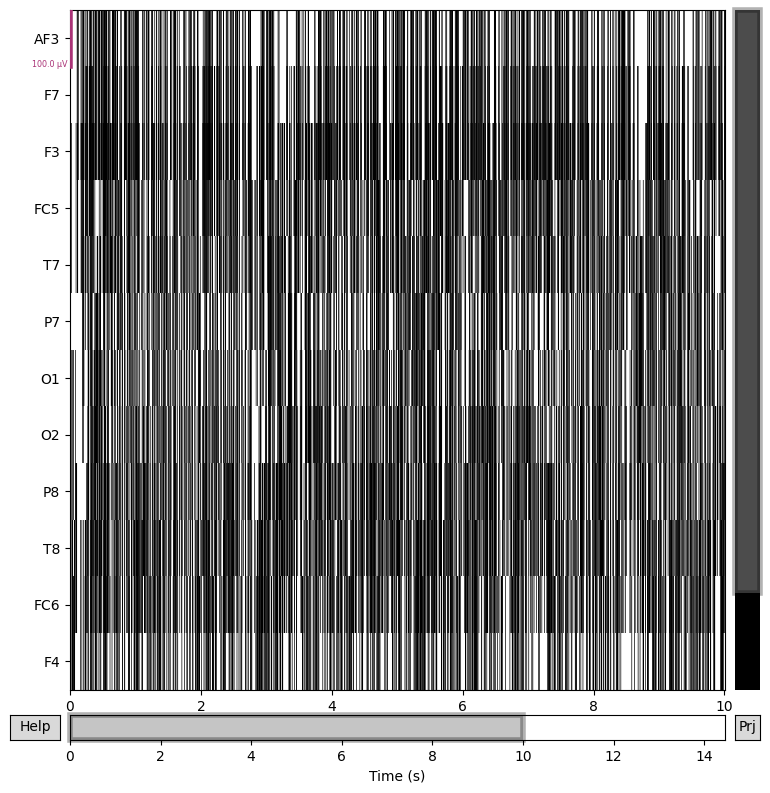

NaN values found in the following locations:
        AF3     F7     F3    FC5     T7     P7     O1     O2     P8     T8  \
0     False  False  False  False  False  False  False  False  False  False   
1     False  False  False  False  False  False  False  False  False  False   
2     False  False  False  False  False  False  False  False  False  False   
3     False  False  False  False  False  False  False  False  False  False   
4     False  False  False  False  False  False  False  False  False  False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1846  False  False  False  False  False  False  False  False  False  False   
1847  False  False  False  False  False  False  False  False  False  False   
1848  False  False  False  False  False  False  False  False  False  False   
1849  False  False  False  False  False  False  False  False  False  False   
1850  False  False  False  False  False  False  False  False  False  False   

        FC6     F4

<ipython-input-17-53a9301fa6db>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-17-53a9301fa6db>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)


In [17]:
# Interpolation and NaN handling for the Raw object after ICA and filtering
def interpolate_and_handle_nans(raw_cleaned):
    try:
        # Step 1: Interpolate bad channels
        bad_channels = raw_cleaned.info['bads']
        raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels
        raw_cleaned.plot(n_channels=12, scalings=dict(eeg=50e-6))

        # Step 2: Handle NaN values in the EEG data
        eeg_data = pd.DataFrame(raw_cleaned.get_data().T, columns=raw_cleaned.ch_names)
        nan_locations = eeg_data.isna()

        # Print locations of NaN values
        print("NaN values found in the following locations:")
        print(nan_locations)

        # Step 3: Interpolate NaN values in the EEG data
        eeg_data_interpolated = eeg_data.interpolate(method='linear', axis=0)

        # Step 4: Check if any NaN values remain after interpolation
        nan_check = eeg_data_interpolated.isna().sum()
        print("Remaining NaN values after interpolation per column:")
        print(nan_check)

        # Step 5: Replace remaining NaNs with forward fill or backward fill
        eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')

        # Final check for remaining NaN values
        remaining_nans = eeg_data_interpolated.isna().sum()
        print(f"Remaining NaN values after interpolation: {remaining_nans}")

        # Step 6: Mark and interpolate bad channels in the Raw object
        raw_cleaned.info['bads'] = [ch for ch in bad_channels if ch in raw_cleaned.info['ch_names']]
        raw_cleaned.interpolate_bads(reset_bads=True)

        # Update Raw object with interpolated EEG data
        raw_cleaned = mne.io.RawArray(eeg_data_interpolated.T.to_numpy(), raw_cleaned.info)
        return raw_cleaned

    except Exception as e:
        print(f"Error during interpolation and NaN handling: {e}")
        return raw_cleaned

# Process the Raw object for interpolation and NaN handling for a single participant
def process_interpolation(raw_cleaned):
    print("Processing Raw object for interpolation and NaN handling.")

    try:
        # Apply interpolation and NaN handling
        interpolated_raw = interpolate_and_handle_nans(raw_cleaned)

        print("Successfully processed and cleaned Raw object for interpolation.")
        return interpolated_raw

    except Exception as e:
        print(f"Failed to process Raw object for interpolation: {e}")
        return None  # Return None in case of failure

# Assuming cleaned_raw_participant_data is the cleaned Raw object for the single participant
interpolated_raw_participant_data = process_interpolation(cleaned_raw_participant_data)

In [18]:
# Function to apply Z-score normalization to EEG data
def z_score_normalize_eeg_data(raw):
    eeg_data = raw.get_data()
    mean = np.mean(eeg_data, axis=1, keepdims=True)
    std = np.std(eeg_data, axis=1, keepdims=True)
    normalized_data = (eeg_data - mean) / std
    raw._data = normalized_data
    print("Applied Z-score normalization (zero mean, unit variance).")
    return raw

# Process the Raw object for Z-score normalization for a single participant
def process_z_score_normalization(raw_cleaned):
    print("Processing Raw object for Z-score normalization.")

    try:
        # Apply Z-score normalization
        normalized_raw = z_score_normalize_eeg_data(raw_cleaned)

        print("Successfully applied Z-score normalization to Raw object.")
        return normalized_raw

    except Exception as e:
        print(f"Failed to process Raw object for Z-score normalization: {e}")
        return None  # Return None in case of failure

# Assuming interpolated_raw_participant_data is the interpolated Raw object for the single participant
normalized_raw_participant_data = process_z_score_normalization(interpolated_raw_participant_data)

Processing Raw object for Z-score normalization.
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization to Raw object.


In [19]:
# Define the segment length in seconds
SEGMENT_LENGTH_SECONDS = 2  # Duration of each segment
segment_length = FS * SEGMENT_LENGTH_SECONDS  # Number of rows per segment

# Function to segment the EEG data for a single participant
def segment_eeg_data(raw_data):
    print("Segmenting data for the participant.")

    if isinstance(raw_data, mne.io.RawArray):
        # Extract raw numerical data
        data = raw_data.get_data().T
        num_segments = len(data) // segment_length

        # Create segments
        segments = [
            data[i * segment_length: (i + 1) * segment_length]
            for i in range(num_segments)
        ]

        # Optional: Handle partial segment
        if len(data) % segment_length != 0:
            partial_segment = data[num_segments * segment_length:]
            print(f"Partial segment with length {len(partial_segment)}")

        print(f"  {len(segments)} full segments created for the participant.")
        return segments
    else:
        print(f"Unsupported data type: {type(raw_data)}")
        return None  # Return None in case of failure

# Process the Raw object for segmentation for a single participant
def process_segmentation(raw_cleaned):
    segments = segment_eeg_data(raw_cleaned)

    if segments is not None:
        # Convert list of numpy arrays into a single DataFrame
        flat_segments = []
        for i, segment in enumerate(segments):
            # Flatten each segment and add a segment ID (optional)
            segment_df = pd.DataFrame(segment)
            segment_df['Segment_ID'] = i
            flat_segments.append(segment_df)

        # Combine all segments into one DataFrame
        df = pd.concat(flat_segments, ignore_index=True)

        # Save the DataFrame to a CSV
        save_path = os.path.join('/content/drive/MyDrive/preprocessed words', "participant_segmented_data.csv")
        df.to_csv(save_path, index=False)
        print(f"Saved participant segmented data to {save_path}")

# Assuming normalized_raw_participant_data is the normalized Raw object for the single participant
process_segmentation(normalized_raw_participant_data)

Segmenting data for the participant.
Partial segment with length 59
  7 full segments created for the participant.
Saved participant segmented data to /content/drive/MyDrive/preprocessed words/participant_segmented_data.csv
